Practical 3-1: Text Classification With RNN

Oxford CS - Deep NLP 2017
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/

[Yannis Assael, Brendan Shillingford, Chris Dyer]

This practical is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In [1]:
import numpy as np
import os
from random import shuffle
import re

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Data preparation

In [3]:
import urllib.request
import zipfile
import lxml.etree

In [4]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [5]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))

In [6]:
texts=doc.xpath('//content/text()')
keywords=doc.xpath('//keywords/text()')
del doc

In [7]:
#parse keywords into lables
def keyword2Label(keyword):
    temp=keyword.lower()
    ans="ooo"
    if temp.find("technology")!=-1:
        ans='T'+ans[1:]
    if temp.find("entertainment")!=-1:
        ans=ans[0]+'E'+ans[2]
    if temp.find("design")!=-1:
        ans=ans[:2]+'D'
    return ans
labels=list(map(keyword2Label,keywords))
print(keywords[:10])
print(labels[:10])

['talks, business, creativity, curiosity, goal-setting, innovation, motivation, potential, success, work', 'talks, Planets, TEDx, bacteria, biology, engineering, environment, evolution, exploration, future, innovation, intelligence, microbiology, nature, potential, science', 'talks, Debate, Guns, activism, big problems, children, choice, community, future, goal-setting, government, law, leadership, marketing, parenting, policy, social change, violence', 'talks, Brazil, Slavery, art, beauty, community, creativity, culture, design, global issues, humanity, identity, photography, race, social change, society, visualizations', 'talks, NASA, communication, computers, creativity, design, engineering, exploration, future, innovation, interface design, invention, microsoft, potential, prediction, product design, technology, visualizations', 'talks, Africa, Internet, community, democracy, development, future, government, identity, leadership, politics, potential', 'talks, ancient world, animals

In [8]:
#clean the texts
def cleanText(text):
    ans = re.sub(r'\([^)]*\)', '', text)
    sentences_strings_ted = []
    for line in ans.split('\n'):
        m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
    sentences_ted = []
    for sent_str in sentences_strings_ted:
        tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
        if len(tokens)>0:
            sentences_ted.append(tokens)
    return sentences_ted

for i in range(len(texts)):
    text=cleanText(texts[i])
    texts[i]=text

In [9]:
raw_data=list(zip(texts,labels))
import random
random.shuffle(raw_data)
raw_train=raw_data[:1585]
raw_val=raw_data[1585:1835]
raw_test=raw_data[1835:]

In [10]:
#handle raw train, record a counter and transform the rare word in train and the unseen data in val\test as <unseen>
# ...
import collections
counter=collections.Counter()
for text_label in raw_train:
    text=text_label[0]
    for sentence in text:
        counter.update(sentence)
        
def handle_unseen(raw_train,counter=counter,min_count=10):
    for text_label in raw_train:
        text=text_label[0]
        for sentence in text:
            for i in range(len(sentence)):
                if counter.get(sentence[i],0)<min_count:
                    sentence[i]='<UNK>'
    return

handle_unseen(raw_train)
handle_unseen(raw_val)
handle_unseen(raw_test)
                

In [11]:
#show hist of label
import seaborn as sns
import collections
import matplotlib.pyplot as plt

def show_pie(raw_train):
    counter=collections.Counter()
    for text_label in raw_train:
        label=text_label[1]
        counter.update([label])
        
    labels = []
    fracs = []
    for k in counter:
        labels.append(k)
        fracs.append(counter.get(k))
    plt.axes(aspect=1)  # set this , Figure is round, otherwise it is an ellipse
    #autopct ，show percet
    plt.pie(x=fracs, labels=labels,autopct='%3.1f %%',
            shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
    plt.show()
    


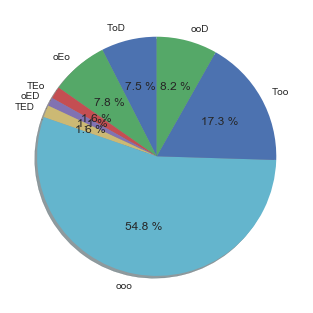

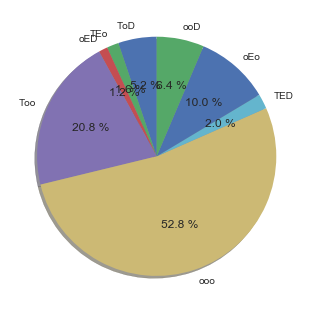

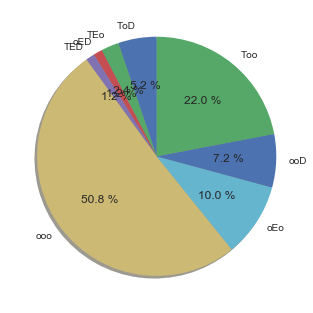

In [12]:
show_pie(raw_train)
show_pie(raw_val)
show_pie(raw_test)

Word embedding

Train a word2vec model on train data

In [13]:
from gensim.models import Word2Vec

C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
# ...
sentences_ted=[]
for text_label in raw_train:
    text=text_label[0]
    for sentence in text:
        sentences_ted.append(sentence)
        
print(sentences_ted[0])
print(sentences_ted[1])

['every', 'day', 'i', 'listen', 'to', '<UNK>', 'stories', 'of', 'people', 'fleeing', 'for', 'their', 'lives', 'across', 'dangerous', 'borders', 'and', '<UNK>', 'seas']
['but', 'there', 's', 'one', 'story', 'that', 'keeps', 'me', 'awake', 'at', 'night', 'and', 'it', 's', 'about', 'doaa']


In [15]:
model_ted = Word2Vec(sentences_ted, size=100, min_count=10, workers=3)

In [16]:
model_ted.most_similar("man")

[('woman', 0.8728659152984619),
 ('guy', 0.8407812714576721),
 ('lady', 0.809897780418396),
 ('girl', 0.7688450217247009),
 ('soldier', 0.7427219748497009),
 ('boy', 0.7354326248168945),
 ('kid', 0.7157387733459473),
 ('doctor', 0.7088638544082642),
 ('gentleman', 0.6943600177764893),
 ('surgeon', 0.6863460540771484)]

In [17]:
model_ted.most_similar("march")

[('december', 0.8991042971611023),
 ('june', 0.8704606294631958),
 ('january', 0.8642600774765015),
 ('september', 0.8641218543052673),
 ('october', 0.8459576368331909),
 ('april', 0.8415054678916931),
 ('2001', 0.8363568782806396),
 ('february', 0.8254663944244385),
 ('july', 0.8238472938537598),
 ('2005', 0.8197237253189087)]

In [18]:
model_ted.most_similar("<UNK>")

[('de', 0.7103893160820007),
 ('james', 0.6317135095596313),
 ('king', 0.6295051574707031),
 ('jack', 0.6290245652198792),
 ('bell', 0.6254600286483765),
 ('greek', 0.6250304579734802),
 ('cyrus', 0.624010443687439),
 ('van', 0.6239060163497925),
 ('george', 0.6154741644859314),
 ('robert', 0.6085925102233887)]

In [19]:
#now use the model to transform our raw data into vector 
model_ted['<UNK>']

array([ 0.13469546,  0.89134115, -0.69677746,  0.31649068, -0.76856887,
        0.16964501, -0.54985052, -0.14770795,  0.24407338,  0.25335369,
        0.67366207,  0.34244442,  0.25935042, -0.1844303 , -0.21321735,
       -0.28227472,  1.02033174, -0.0329878 ,  0.58373892,  0.37522468,
       -0.00579357, -0.23702581,  0.20221058,  0.1706282 ,  0.00184217,
        0.40078637,  0.03164975, -0.11762254,  0.85845053,  0.79272366,
       -0.31428027, -0.37296638, -0.55561751,  0.47777033,  0.53707063,
       -0.03078513, -0.30591059, -0.26738566,  0.49917653,  0.47775418,
        0.63238072,  0.52367193, -0.1527447 , -0.41283059, -0.39411274,
       -1.02419209,  0.13013181,  0.18727057, -0.18762368, -0.61425102,
       -0.23575307,  1.2581073 , -0.143336  ,  0.63018966, -0.60336554,
       -0.78490067,  1.0038116 ,  0.13957573,  0.37940907,  0.43173361,
       -0.37457919, -0.00891738,  0.87748396, -0.49563235,  0.18268567,
       -0.20421202,  0.53303033,  0.02937459, -0.40575293,  0.37

In [20]:
#generate word table
word2idx={}
j=1
for i in range(len(raw_train)):
    text_label=raw_train[i]
    text,label=text_label
    ans_text=[]
    for sentence in text:
        for word in sentence:
            if word not in word2idx:
                word2idx[word]=j
                j+=1


In [21]:
word_embedding=np.zeros((len(word2idx)+1,100))
for word in word2idx:
    word_embedding[word2idx[word]]=model_ted[word]
word_embedding.shape

(12503, 100)

In [22]:
def gen_data(raw_train):
    ans_X=[]
    ans_y=[]
    temp=['ooo','Too','oEo','ooD','TEo', 'ToD','oED','TED']
    for i in range(len(raw_train)):
        text_label=raw_train[i]
        text,label=text_label
        ans_text=[]
        for sentence in text:
            for word in sentence:
                ans_text.append(word2idx[word])
        #print(ans_text)
        ans_text=np.array(ans_text).astype('int32')
        if(ans_text.shape[0]==0):
            continue
        #ans_text=np.mean(ans_text,axis=0)
        #print(ans_text.shape)
        ans_label=np.zeros(8)
        ans_label[temp.index(label)]=1
        ans_X.append(ans_text)
        ans_y.append(ans_label)
    return np.array(ans_X),np.array(ans_y)



In [23]:
train_X,train_y=gen_data(raw_train)
val_X,val_y=gen_data(raw_val)
test_X,test_y=gen_data(raw_test)

In [24]:
train_X.shape

(1580,)

In [25]:
train_X[0]

array([  1,   2,   3, ..., 649, 650, 109])

In [26]:
lens=np.zeros(train_X.shape)
for i in range(len(train_X)):
    lens[i]=len(train_X[i])

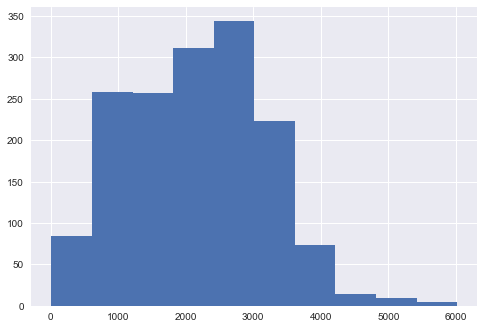

In [27]:
plt.hist(lens)
plt.show()

In [28]:
#padding every ted to 400
def padding(train_X,NUM_STEP=400):
    ans=np.zeros((len(train_X),NUM_STEP))
    for i in range(len(train_X)):
        temp=list(train_X[i])
        if len(temp)>NUM_STEP:
            temp=temp[:NUM_STEP]
        else:
            temp+=[0]*(NUM_STEP-len(temp))
        ans[i]=np.array(temp)
    return ans

In [29]:
train_X=padding(train_X)
val_X=padding(val_X)
test_X=padding(test_X)

Text Classifier

In [30]:
import tensorflow as tf

In [31]:
import time

class TextClassifierModel(object):
    def __init__(self,hidden_size=100,learning_rate=1e-3,classes=8,lambda2=1e-3,doc_embedding=100,batch_size=50):
        print('Initialize new model')
        self.classes=classes
        self.learning_rate=learning_rate
        self.hidden_size=hidden_size
        self.lambda2=lambda2
        self.doc_embedding=doc_embedding
        self.batch_size=batch_size
    
    def _create_placeholders(self):
        # Feeds for inputs. It's a list of placeholders
        print('Create placeholders')
        self.texts=tf.placeholder(tf.int32, shape=(None,400), name='texts')
        self.labels = tf.placeholder(tf.float32, shape=(None, self.classes),
                                        name='labels')
        self.dropout_proba = tf.placeholder(tf.float32, shape=(), name='dropout_proba')
        
    def _create_word_embedding(self):
        # Feeds for inputs. It's a list of placeholders
        print('Create embedding')
        with tf.name_scope("embedding"):
            self._embedding=tf.Variable(word_embedding,name='embed_matrix',trainable=False,dtype=tf.float32)
            
    def _doc_embedding(self):
        embed = tf.nn.dropout(tf.nn.embedding_lookup(self._embedding, self.texts, name='embed'),self.dropout_proba)
        with tf.name_scope("rnn"):
            cell1 = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(self.doc_embedding),output_keep_prob=self.dropout_proba)
            cell2 = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(self.doc_embedding),output_keep_prob=self.dropout_proba)
            in_state1 = cell1.zero_state(tf.shape(self.texts)[0], tf.float32)
            in_state2 = cell2.zero_state(tf.shape(self.texts)[0], tf.float32)
            output, out_state = tf.nn.bidirectional_dynamic_rnn(cell1,cell2, embed, initial_state_fw=in_state1,
                                                               initial_state_bw=in_state2)
            return tf.reduce_mean(tf.concat(output,axis=2),axis=1)
        
    def _inference(self):
        print('Create inference')
        with tf.name_scope("network"):
            x = self._doc_embedding()
            w = tf.Variable(tf.random_normal([2*self.doc_embedding,self.hidden_size], stddev=0.1),name="w")
            b = tf.Variable(tf.zeros([self.hidden_size]))
            h = tf.nn.dropout(tf.nn.relu(tf.matmul(x,w)+b),self.dropout_proba)
            v = tf.Variable(tf.random_normal([self.hidden_size,self.classes], stddev=0.1),name="v")
            c = tf.Variable(tf.zeros([self.classes]))        
            u = tf.matmul(h,v)+c
        self._u=u
        self._w=w
        self._v=v

            

    def _create_loss(self):
        print('Creating loss...')
        start = time.time()
        with tf.name_scope("loss"):
            loss=tf.nn.softmax_cross_entropy_with_logits(
                logits=self._u,labels=self.labels)
            self.loss=tf.reduce_mean(loss)+self.lambda2*(tf.nn.l2_loss(self._w)+tf.nn.l2_loss(self._v))
        print('Time:', time.time() - start)


    def _creat_optimizer(self):
        print('Create optimizer...')
        with tf.name_scope("optimizer"):
            self.optimizer =tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            
    def _creat_accuracy(self):
        print('Create accuracy...')
        with tf.name_scope("accuracy"):
            preds = tf.nn.softmax(self._u)
            correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(self.labels, 1))
            self.accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))/(tf.cast(tf.shape(self.labels)[0], tf.float32))


    def _create_summary(self):
        pass

    def build_graph(self):
        self._create_placeholders()
        self._create_word_embedding()
        self._inference()
        self._create_loss()
        self._creat_optimizer()
        self._create_summary()
        self._creat_accuracy()


In [32]:
model = TextClassifierModel(learning_rate=0.01,hidden_size=50,lambda2=1e-4)
model.build_graph()

Initialize new model
Create placeholders
Create embedding
Create inference
Creating loss...
Time: 0.03305864334106445
Create optimizer...
Create accuracy...


In [34]:

saver = tf.train.Saver()
batch_size=50
n_epochs=20

with tf.Session() as sess:
    writer = tf.summary.FileWriter('./my_graph', sess.graph)

    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    n_batches = int(train_X.shape[0]/batch_size)
    for i in range(n_epochs): # train the model n_epochs times
        total_loss = 0

        for j in range(n_batches):
            X_batch, Y_batch = train_X[j*batch_size:(j+1)*batch_size],train_y[j*batch_size:(j+1)*batch_size]
#             print(X_batch.shape)
#             print(Y_batch.shape)
            _, loss_batch = sess.run([model.optimizer, model.loss], feed_dict={model.texts: X_batch,
                                                                               model.labels:Y_batch,model.dropout_proba:0.7}) 
            total_loss += loss_batch
        print('Average train loss epoch {0}: {1}'.format(i, total_loss/n_batches))
        print('Average train accuracy epoch {0}: {1}'.format(i, sess.run([model.accuracy], feed_dict={model.texts: train_X,
                                                                               model.labels:train_y,model.dropout_proba:1})[0]))
        print('Average val accuracy epoch {0}: {1}'.format(i, sess.run([model.accuracy], feed_dict={model.texts: val_X,
                                                                               model.labels:val_y,model.dropout_proba:1})[0]))

    print('Total time: {0} seconds'.format(time.time() - start_time))

    print('Optimization Finished!') 

    # test the model
    print('Average test accuracy : {0}'.format( sess.run([model.accuracy], feed_dict={model.texts: test_X,
                                                                               model.labels:test_y,model.dropout_proba:1})[0]))

    writer.close()


Average train loss epoch 0: 1.5405014791796285
Average train accuracy epoch 0: 0.5481012463569641
Average val accuracy epoch 0: 0.5322580933570862
Average train loss epoch 1: 1.3525764480713875
Average train accuracy epoch 1: 0.5481012463569641
Average val accuracy epoch 1: 0.5322580933570862
Average train loss epoch 2: 1.3209074428004604
Average train accuracy epoch 2: 0.5677215456962585
Average val accuracy epoch 2: 0.5524193644523621
Average train loss epoch 3: 1.2603845827041134
Average train accuracy epoch 3: 0.5816455483436584
Average val accuracy epoch 3: 0.5806451439857483
Average train loss epoch 4: 1.2066354136313162
Average train accuracy epoch 4: 0.5791139006614685
Average val accuracy epoch 4: 0.5524193644523621
Average train loss epoch 5: 1.1860969816484759
Average train accuracy epoch 5: 0.6297468543052673
Average val accuracy epoch 5: 0.5524193644523621
Average train loss epoch 6: 1.1186783794433839
Average train accuracy epoch 6: 0.6183544397354126
Average val accuracy